In [1]:
import os

# DATA UNDERSTANDING

In [105]:
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt

In [101]:
loads_data = np.load('datasets/loads.npy')
injections_data = np.load('datasets/injections.npy')

with open('datasets/adjacency.json', 'r') as file:
    adjacency_data = json.load(file)


print("Loads Data Shape:", loads_data.shape)
print("Injections Data Shape:", injections_data.shape)

Loads Data Shape: (10000, 20)
Injections Data Shape: (10000, 14)


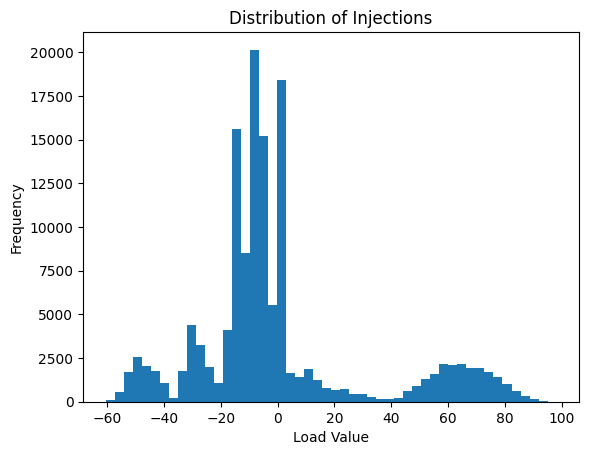

In [103]:
plt.hist(injections_data.flatten(), bins=50)
plt.title("Distribution of Injections")
plt.xlabel("Load Value")
plt.ylabel("Frequency")
plt.show()

Based on the histograms provided for the distributions of injections and loads:

### Distribution of Injections:
- The histogram shows a multimodal distribution with several peaks, which suggests distinct groups or operational modes within the data.
- There is a significant peak around zero, indicating that a substantial number of timesteps or buses have no net injection (neither generation nor consumption).
- The spread of negative values indicates periods or buses with net consumption, while positive values indicate net generation.
- The presence of both high positive and high negative values could indicate extreme cases of generation or consumption.

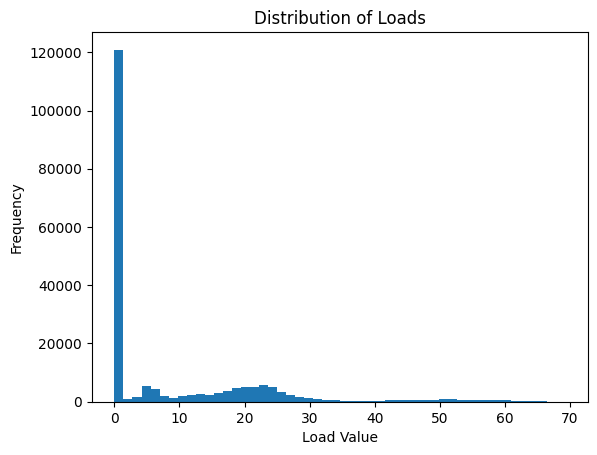

In [102]:
plt.hist(loads_data.flatten(), bins=50)
plt.title("Distribution of Loads")
plt.xlabel("Load Value")
plt.ylabel("Frequency")
plt.show()

### Distribution of Loads:
- The histogram for loads shows a heavily right-skewed distribution with most of the data concentrated near zero and a long tail extending to the right.
- The high frequency at the lower end suggests that many branches carry low currents relative to their capacity.
- The long tail indicates that there are fewer instances where branches carry higher loads, which are critical to identify for potential overloads.

### Should We Normalize the Data?

Normalization might be beneficial here for several reasons:
- **Model Training**: Many machine learning models, including neural networks, perform better when the input features have similar scales.
- **Outlier Impact Reduction**: Normalization can reduce the impact of outliers or extreme values, leading to more stable training.
- **Comparability**: Normalized data can make it easier to compare the importance of different features and can help the model learn more effectively.

we will use **log normal normalization** for the loads and **normal normalization** for the injections

## Should We Remove loads values above 5?

(Not the case here) We could have consider two conditions (two training) : for loads in normal time and loads with expected higher value.

## Time series understanding

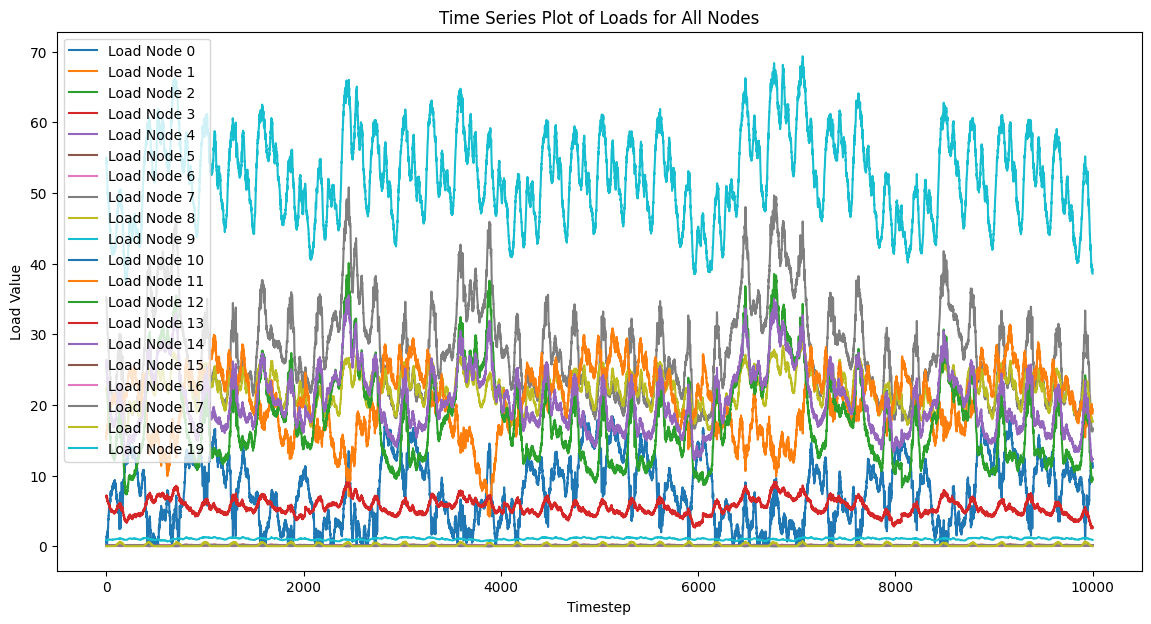

In [109]:
plt.figure(figsize=(14, 7))
for i in range(loads_data.shape[1]):
    plt.plot(loads_data[:, i], label=f'Load Node {i}')
plt.xlabel('Timestep')
plt.ylabel('Load Value')
plt.title('Time Series Plot of Loads for All Nodes')
plt.legend()
plt.show()


### Time Series Plot of Loads for All Nodes:
- There is a clear variation in the magnitude of loads across different nodes, with some nodes consistently experiencing higher loads than others.
- Several nodes show similar patterns of fluctuation over time, which may indicate correlated or synchronized behavior, possibly due to similar operational schedules or shared dependencies.
- The presence of spikes in the loads could represent peak usage times or specific events that cause load surges.

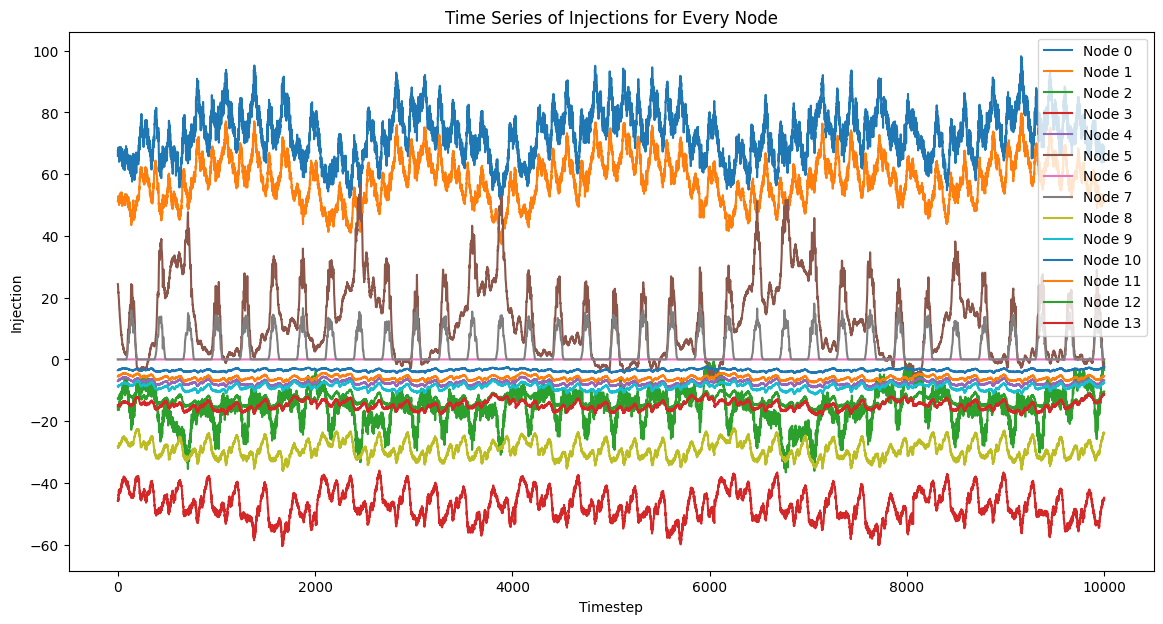

In [110]:
plt.figure(figsize=(14, 7))
for node in range(injections_data.shape[1]): 
    plt.plot(injections_data[:, node], label=f'Node {node}')
plt.xlabel('Timestep')
plt.ylabel('Injection')
plt.title('Time Series of Injections for Every Node')
plt.legend() 
plt.show()

### Time Series Plot of Injections for Every Node:
- Similar to loads, injections also vary significantly across nodes, with certain nodes showing much higher injections, likely representing generation sources.
- The injections for some nodes appear to be negative, indicating these nodes are consumption points rather than generation points.
- There is a periodic or cyclic pattern in the injections for several nodes, possibly reflecting operational cycles such as daily or weekly patterns.

### Analysis:
- **Cyclical Patterns**: Both loads and injections exhibit cyclic behavior, suggesting that time-based features (like hour of the day, day of the week) may be important predictors for the model.
- **Node Behavior**: Nodes demonstrate different levels of activity, which suggests that individual node features could be important for the model. For example, if certain nodes are more prone to underestimation of loads, the model might need to be adjusted to account for this.
- **Peaks and Troughs**: The peaks in loads and injections might be critical points for the model to capture accurately, especially if the peaks in loads correspond to the highest risk of system overload.
- **Normalization**: Given the wide range of values, especially in injections, normalization might help the model perform better by scaling all nodes to a similar range.
- **Correlation**: It would be valuable to compute correlations not only between loads and injections for the same nodes but also between different nodes to capture the network effect.

### Next Steps:
- **Feature Engineering (not done for this project)**: Create time-based features to help the model capture cyclic patterns. Additionally, node-specific features might be important.
- **Normalization**: Apply appropriate normalization to the features to ensure the model is not biased by the scale of different nodes.
- **Model Adjustments(not done for this project)**: Consider customizing the model to give more weight to errors during peak load times, or to focus more on nodes that are more critical to the system’s stability.
- **Correlation Analysis**: Beyond visual analysis, statistical tests could be applied to determine significant correlations, which might inform feature selection and engineering.

Overall, the key takeaway is that there's a complex, multi-node dynamic that needs to be accounted for in the model. Understanding these dynamics will be crucial for improving the model's predictions and addressing underestimation issues.

### Correlation

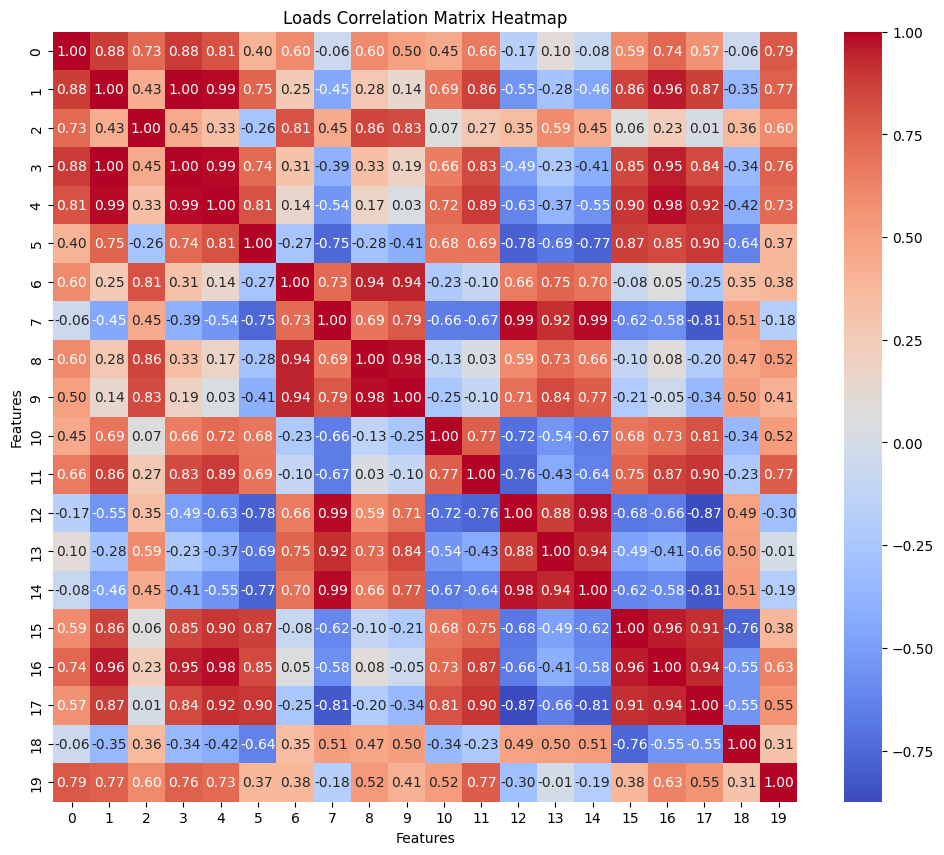

In [112]:
correlation_matrix = np.corrcoef(loads_data.T)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Loads Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

From the correlation matrix heatmaps you provided, we can deduce the following:

### Loads Correlation Matrix Heatmap:
- The heatmap displays a high degree of correlation between many pairs of nodes, with many values close to 1 or -1. This indicates a strong positive or negative linear relationship.
- The positive correlations suggest that when the load on one node increases, the load on another node tends to also increase. This could indicate that certain nodes are likely to experience load changes simultaneously, perhaps due to shared demand or operational characteristics.
- The negative correlations are less frequent but still present, indicating that as the load on one node increases, the load on another node decreases, which could suggest compensatory mechanisms or inverse relationships in the grid operation.

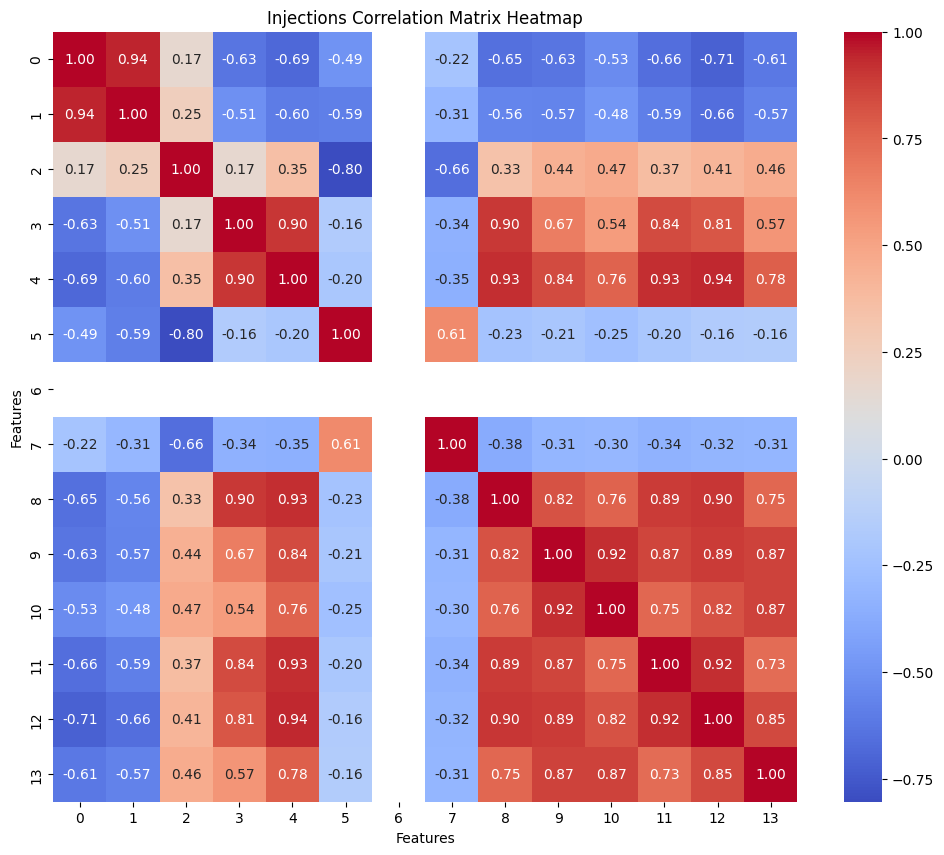

In [113]:
correlation_matrix = np.corrcoef(injections_data.T)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Injections Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

### Injections Correlation Matrix Heatmap:
- The correlations among injections are less uniform than loads, with a mix of strong positive, strong negative, and weak correlations. 
- This varied pattern could reflect the complex interplay between different generation and consumption nodes within the power grid. Generation at one node may not necessarily align with generation at another due to different operational schedules, types of generation sources, or demand patterns.


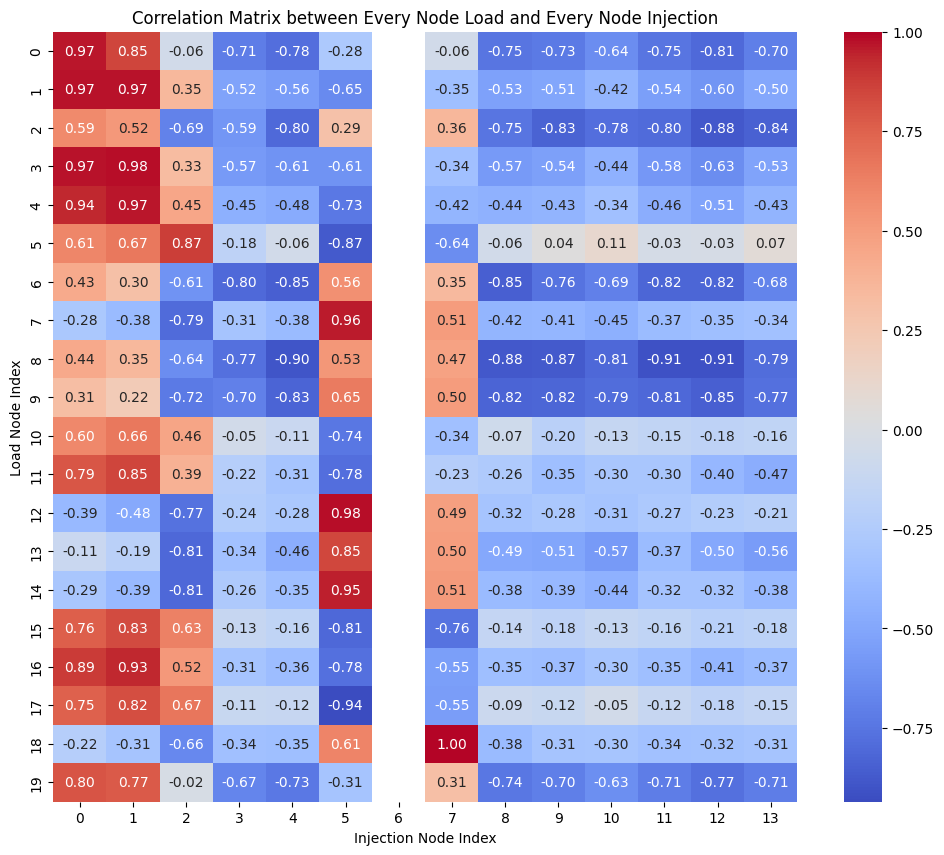

In [114]:
loads_injections_corr = np.corrcoef(loads_data.T, injections_data.T)

num_nodes = loads_data.shape[1]
load_injection_correlation_matrix = loads_injections_corr[:num_nodes, num_nodes:]

plt.figure(figsize=(12, 10))
sns.heatmap(load_injection_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Every Node Load and Every Node Injection')
plt.xlabel('Injection Node Index')
plt.ylabel('Load Node Index')
plt.show()

The correlation matrix between every node load and every node injection provides a comprehensive view of how the power injections at different nodes correlate with the loads at all other nodes.

### Observations:
- **High Positive Correlations**: There are numerous cells with high positive values close to 1. This indicates a strong direct relationship where higher injections at a node are associated with higher loads at other nodes. This could suggest that certain generation nodes directly supply power to specific consumption nodes.
- **High Negative Correlations**: Several cells show high negative values. This could indicate an inverse relationship where higher injections at a node correspond to lower loads at another node. This might occur in a network configuration where increases in generation at one node allow for load reductions at another, possibly due to load sharing or distribution strategies.
- **Neutral to Low Correlations**: Cells with values close to zero indicate little to no linear relationship between injections at one node and loads at another. This suggests that the power generation or consumption at these nodes operates independently of each other.

### Implications for the Model:
- Nodes with strong positive or negative correlations could be critical for the model to learn from since they may represent key supply-demand relationships within the grid.
- The model may benefit from learning the dependencies between nodes with high positive correlations to better predict loads during peak generation times.
- Nodes with high negative correlations might indicate opportunities for the model to learn about load balancing strategies within the grid.

### Next Steps:

1. **Temporal Features**:
   - If we have timestamp information, we can create temporal features such as hour of the day, day of the week, and possible lag features that show past load and injection values.

3. **Update the Model for Temporal Input**:
   - We could also explore Transformer models or message passing models, which have shown great success in handling sequential data with complex interactions.